In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#import scipy.misc
import imageio
from idx_tools import Idx
import os

%matplotlib inline 

## Extracting letters from an image

So, the first step will be to extract the individual characters from the images. In order to to make this process more efficient we want to 1) reduce the data, 2) adjust for varying lightning conditions and 3) denoise the result.
The following function takes care of the above points:
<br>
<br>
It first reduces the colored image to a gray scale image. So, we move from three color channels to one gray channel.<br>
Then the function applies an adaptive thrsholding which binarises the image into black and white values (no gray anymore). While normal thresholding would use one thresholding value for the whole imgage, adaptive thresholds set different thresholds for small regions of the image. This way we can take care of varying illumination conditions in the images. For details on thresholding have a look [here](https://docs.opencv.org/3.2.0/d7/d4d/tutorial_py_thresholding.html).<br>

Finally, the function denoises the thresholded image by applying a blur filter.

In [2]:
def convert_image(img, blur=3):
    # Convert to grayscale
    conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding to binarize the image
    conv_img = cv2.adaptiveThreshold(conv_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 4)

    # Blur the image to reduce noise
    conv_img = cv2.medianBlur(conv_img, blur)
    
    return conv_img

Now before we continue, let’s have a look what the above functions are doing.

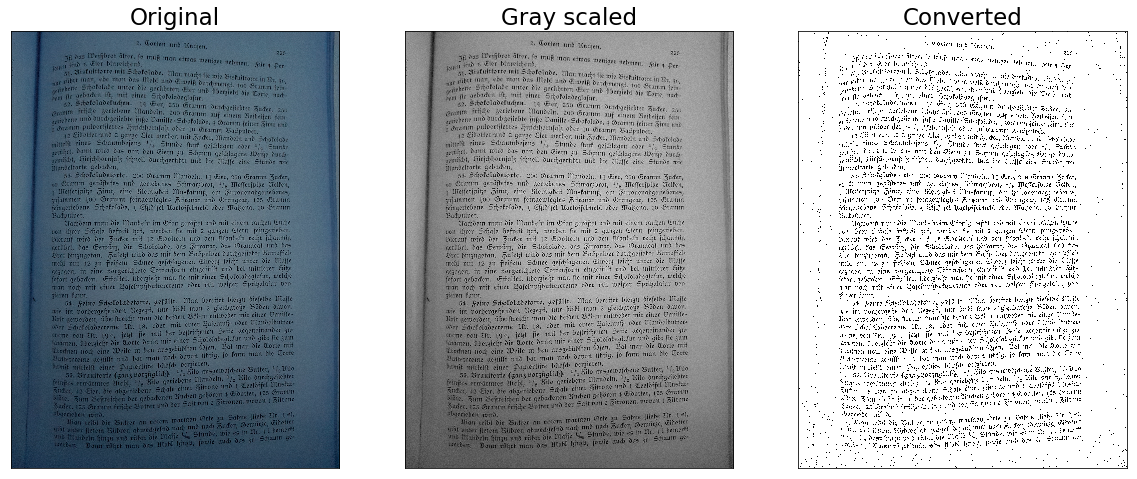

In [3]:
# Read image
img = cv2.imread('./images/01.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
conv_img = convert_image(img)

# Show the effects of each processing stage
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

cmaps = ['jet', 'gray', 'gray']
titles = ['Original', 'Gray scaled', 'Converted']
data = [img, gray, conv_img]
for i in range(3):
    ax[i].imshow(data[i], cmap=cmaps[i])
    ax[i].set_title(titles[i], fontsize=23)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

After converting our input images, we are ready to extract the individual characters. We will use Open CVs *findContours* function for this as follows.

In [4]:
def extract_char(conv_img):
    # Find contours
    _, ctrs, _ = cv2.findContours(conv_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return ctrs

Ok, now what we will get from the above two functions are the x and y coordinates plus the hight and width of all potential letters in an image. But not the images of these letters.<br>

Also, what we need to take care of is how to store the single letter images. The function below will take care off all of this by taking an raw input image, converting it to gray scale and then cutting out the letters according to the coordinates from the *extract_char* function. Further it will draw the bounding boxes for each letter onto the raw image so that we can later get an idea of how well the characters were identified.<br>

In addition, a folder is created (default name: *char*) in which the images are stored. Also, not all of the contours found in the images will be characters. They can be noise or artefacts so we will implement a simple "quality gate" by defining a range of pixels which every image needs to have to be considered as a letter.

In [6]:
def save_char(ctrs, img, lower=600, upper=20000, path='./char'):
    
    # Create the target folder for saving the extracted images
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Convert original image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Number of images already in the target folder
    n = len(os.listdir('./char')) + 1
    
    # Number of potential characters found in the image
    n_char = np.shape(ctrs)[0]
    
    # Go through each potential character
    for i in range(n_char):
        
        # Get coordinates of the potential character
        x, y, w, h = cv2.boundingRect(ctrs[i])
        
        # Test if the number of pixels in the bounding box is reasonable
        if (w * h) > lower and (w * h) < upper:
            
            # Draw the bounding box in the original image
            result = cv2.rectangle(img, (x, y), ( x + w, y + h ), (0, 255, 0), 2)

            # Extract the character and save it as a .jpeg
            roi = gray[y:y+h, x:x+w]
            imageio.imwrite('{}/char_{}.jpg'.format(path, n), roi)
            
            # Increase counter
            n += 1
    
    # Return image with all bounding boxes
    return result

So now is the time to put it all together the code below will take four images, find all potential letters, extract them and store their images on disk.

In [7]:
# List of all images to create the first training data 
image_files = ['./images/01.jpg',
          './images/02.jpg',
          './images/03.jpg',
          './images/04.jpg']

# Go through all files and extract the characters
for file in image_files:

    # Read image
    img = cv2.imread(file)

    # Convert the image (gray/thresholded/blured)
    conv_img = convert_image(img)

    # Find and sort the contours
    ctrs = extract_char(conv_img)

    # Save the result
    result = save_char(ctrs, img)

As mentioned above the *save_char* function also draws the bounding boxes onto the raw image. So let's have a look on how the extraction process worked for the last image (*04.jpeg*).

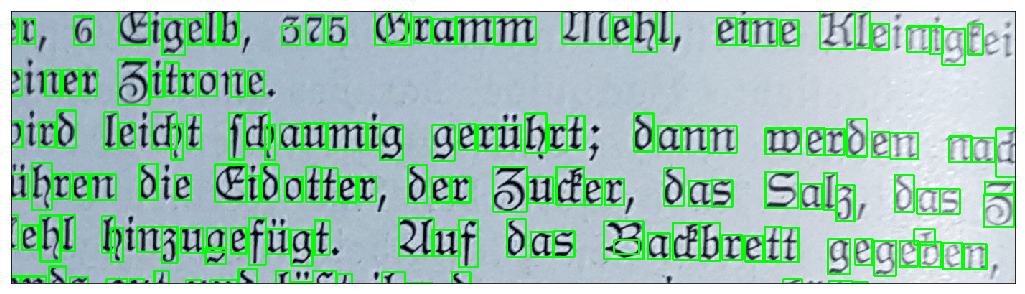

In [8]:
# Plot the result of the last image
fig, ax = plt.subplots(1, 1, figsize=(18, 32))

ax.imshow(result)
ax.set_xlim([1000, 2400])
ax.set_ylim([1800, 1420])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

The result looks quite good; however we can see some things that might give us a hard time later. For example, at the end of the first line the *i'*s are not detected. Also, the letter *ü* is detected as an *u* and the letter *h* and sometimes *g* is detected as two letters.
We will have to see at a later stage how we can fix this. However, for now we can live with it as we want to create a training dataset, not optimize the detection routine.

## Clustering the data

The next step will be to create our labeled dataset. This means all the individual letters that we extracted in the previous part need to be labeled. Doing this all manually is a tedious task. So, we will try to pre-cluster the data as much as possible. However we will not get around some manually work at the end.

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Now, before we start with any clustering, we first need to ensure that all the images have the same size. As we can see from the figure below, currently this is not the case. Each image is the size of its bounding box, which varies over a broad scale. So, in the first step we will resize all images to size of 80x80 pixels and append all of them in a NumPy array.
<br>

![Overview of extracted images](./images/figures/01.png)

In [10]:
# Path to the individual letters
data_path = './char/'

# Target image size
convSize = [80, 80]

# File names of all sample images
files = [data_path + x for x in os.listdir(data_path)]

# Resize images and append to a numpy array
images = []
for file in files:
    img = cv2.imread(file)[:, :, 0]
    img = cv2.resize(img, (convSize[0], convSize[1]))
    img = img.reshape(convSize[0] * convSize[1])
    images.append(img)
    
images = np.array(images, dtype='float64')

Alright now that every image has the same size, we will also have to normalize them for further processing. For this we will use the scikit learn's *StandardScaler*

In [11]:
# Apply StandardScaler on the letter data
scaler = StandardScaler()
scaler.fit(images)
scaled = scaler.transform(images)

Next we will need to reduce the dimensionality of the data. Currently each image contains 80x80 = 6400 pixels or features. This is too much for a clustering algorithm  so we will use Principal Component Analysis (PCA) to reduce the number of dimensions from 6400 to 25. 

In [12]:
# Calculate the first 25 principal componnents
pca = PCA(n_components=25)
pca.fit(scaled)
pca_img = pca.transform(scaled)

Great, now we got everything ready to do some pre-clustering which should help us to bring the dataset from an unlabeled to a labeled state. We will go with K-Means clustering here as it is simple and fast. The only thing that we need to provide is the number of clusters that we expect. If K-Means would give us a perfect result, we would end up with the exact number of letters in the German alphabet. There are 26 letters + 4 special letters (ä,ö,ü, ß) in the German alphabet. Each one of them except ß can appear as a lower or upper case which means in total, we would expect 59 clusters. Additionally, there are 10 numbers (0-9) expected, increasing the number of clusters to 69. Also, there will be artifacts in the data as well as "." and "," etc. which may have been detected. We will therefore go with 100 clusters. This is more than we need but it will be easier to merge clusters later than to break them apart.

In [13]:
# Use K-Means clustering to group the data into 100 clusters
nClusters = 100
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(pca_img)

Alright, now let's have a brief look at the result. For this we will plot the scores of the first three principal components in 3-D space and color them according to their cluster number. 

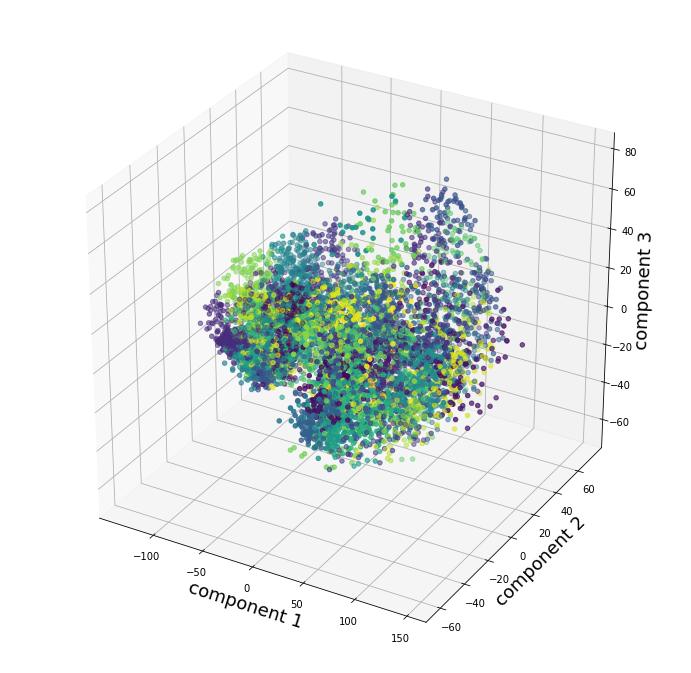

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(pca_img[:, 0], pca_img[:, 1], pca_img[:, 2], c=kmeans.labels_)

ax.set_xlabel('component 1', fontsize=18)
ax.set_ylabel('component 2', fontsize=18)
ax.set_zlabel('component 3', fontsize=18)

plt.show()

It is quite hard to tell from this plot how well the "pre-labeling" worked. We can get a better idea of the clustering result if we move all images into separate folders based on their cluster label. The code below will take care of this and store the results in the folder "clustered".

In [15]:
path = './clustered'

if not os.path.isdir(path):
    os.mkdir(path)

n = 0
for i in range(kmeans.labels_.max()):
    
    cluster_path = '{}/{}'.format(path, i)
    
    if not os.path.isdir(cluster_path):
        os.mkdir(cluster_path)
    
    tmp = images[kmeans.labels_ == kmeans.labels_[i]]
    
    for j in range(np.shape(tmp)[0]):
        tmpImg = np.reshape(tmp[j], convSize).astype(np.uint8)
        imageio.imwrite('{}/{}.jpg'.format(cluster_path, n), tmpImg)
        n += 1
        
# Delete the un-clustered data
[os.remove(data_path + x) for x in os.listdir(data_path)]
os.rmdir(data_path)

By looking into one of the new folders we can see that the clustering worked quite well.
<br>
![Overview of extracted images](./images/figures/02.png)
<br>
Some other clusters however do not look as clean as the above.
<br>
![Overview of extracted images](./images/figures/03.png)
<br>
So now unfortunately there is no automated way forward anymore. The next step is to clean up the clusters manually. This means moving the misclassified images into the correct folders and merging folders with identical letters. After this step we also should name the folders according to their content. Below is an example of how it should look like. As you can see there are usually upper- and lower-case letters found in the images. Since we cannot have folders with the same name we will use "_" to denote the upper-case letters. Also, there are some cases in which two letters become one. For example, the letter sequence "ck" is not separated by any white space and will always be detected by the detection algorithm as one contour so we will create a folder called "ck" to account for this.
<br>
![Overview of extracted images](./images/figures/04.png)
<br>
So, the final step to wrap all of this up is to convert the dataset into the IDX format. You might be familiar with this format already as the famous MNIST dataset is saved in the same way. Only in this case instead of reading the data from an IDX file we must write it.
<br>
We will do so by using the [idx_converter](https://github.com/akcarsten/convert_IDX) which takes a file structure as we set it up in this notebook and directly saves it in the IDX format. The output will be two files: one file with the images and a second file with the labels.
<br>
Since we want to later train a classifier on the data, we should already split the images into a training and a test dataset. For this we will move 30% of the images in each category to a test folder. The code below takes care of all of this. 

In [17]:
# Where is the sorted data located?
dataset_path = './data/' 

# Where should the converted data be stored?
dest_folder = './datasetTMP/' 

# What is the ratio of train vs. test data?
train_percent = 0.7

# Subfolders for structuring the sorted data
train_path = dataset_path + 'train/'
test_path = dataset_path + 'test/'

# Find all folders in the sorted data
folders = os.listdir(dataset_path)

# Create folders
if not os.path.isdir(train_path):
    os.mkdir(train_path)
    os.mkdir(test_path)
    
if not os.path.isdir(dest_folder):
    os.mkdir(dest_folder)
    
# Go through all folders in the sorted data and split into train and test    
for char in folders:
    char_path = dataset_path + char + '/'
    train_folder = train_path + char + '/'
    test_folder = test_path + char + '/'
    
    samples = os.listdir(char_path)
    n_samples = len(samples)
    n_train = round(train_percent * n_samples)
    
    sel = np.arange(n_samples)
    np.random.shuffle(sel)
    
    idx_train = sel[0:n_train] 
    idx_test = sel[n_train:]
    
    if not os.path.isdir(train_folder):
        os.mkdir(train_folder)
        
    if not os.path.isdir(test_folder):
        os.mkdir(test_folder)
    
    [os.rename(char_path + samples[x], train_folder + samples[x]) for x in idx_train]
    [os.rename(char_path + samples[x], test_folder + samples[x]) for x in idx_test]
    
    os.rmdir(char_path)
    
# Convert data to idx format    
Idx.save_idx(train_path)
Idx.save_idx(test_path)

# Move converted dataset to target folder
os.rename(train_path + 'images.idx3-ubyte', dest_folder + 'train-images.idx3-ubyte')
os.rename(train_path + 'labels.idx3-ubyte', dest_folder + 'train-labels.idx3-ubyte')
os.rename(test_path + 'images.idx3-ubyte', dest_folder + 'test-images.idx3-ubyte')
os.rename(test_path + 'labels.idx3-ubyte', dest_folder + 'test-labels.idx3-ubyte')

To make our lives easier later we will also create a txt file with the names of the characters in the dataset. As we discussed above upper-case letters were located in a folder ending with "_". We will take this into account and convert these letters to upper case in the txt file. The code below takes care of all of this.

In [30]:
chars = os.listdir('./data/train')

labelFile = open('{}/labels.txt'.format(dest_folder), "w")
for char in chars:
    
    if char.endswith('_'):
        char = char[:-1].upper()
    
    # write line to output file
    labelFile.write(char)
    labelFile.write("\n")
labelFile.close()